# Generando datos sintéticos para aumentar el volumen de datos por tema

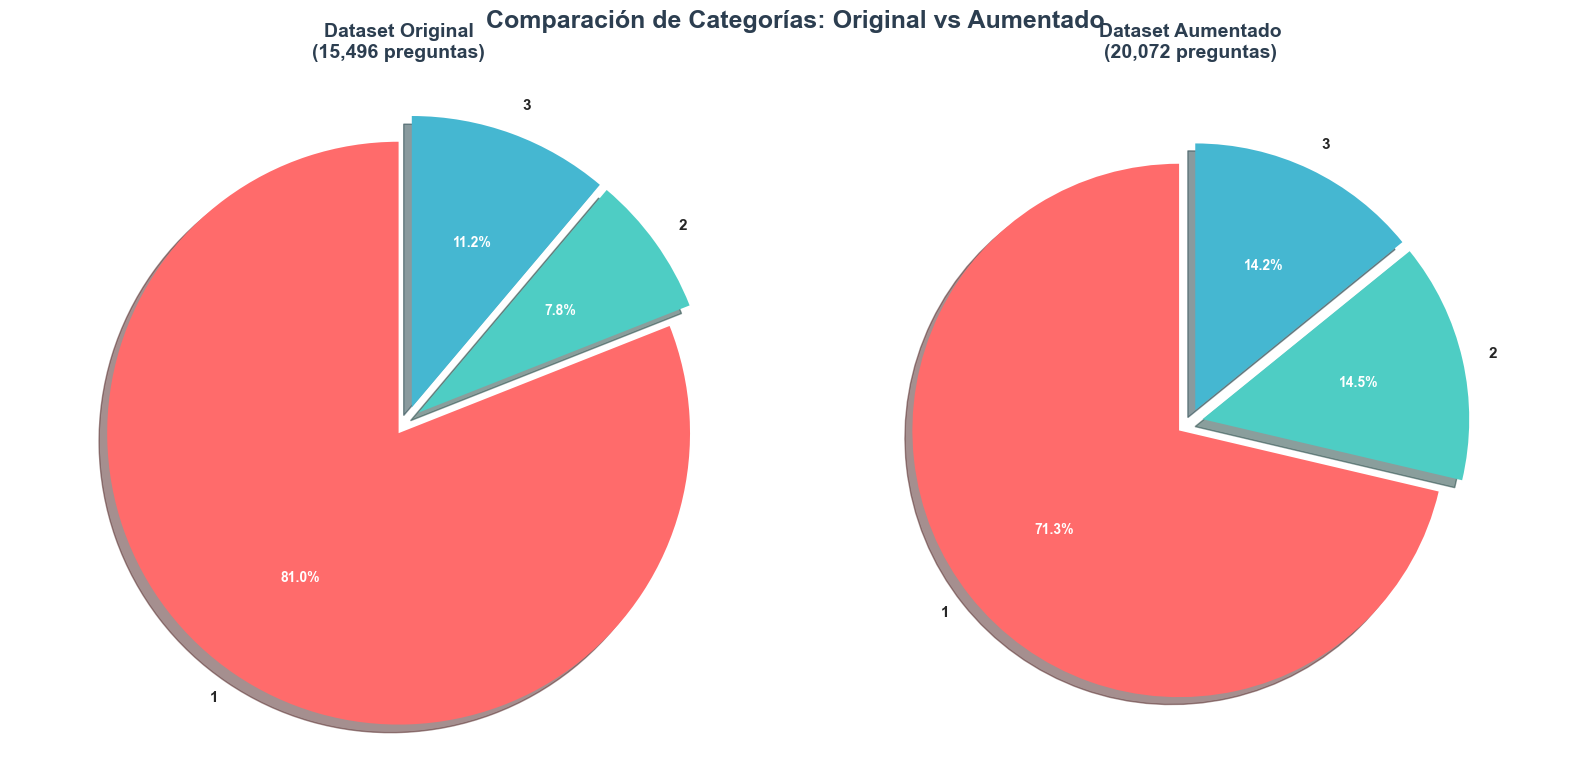

📊 RESUMEN DE COMPARACIÓN
📈 Original: 15,496 preguntas
📈 Aumentado: 20,072 preguntas
➕ Incremento: 4,576 preguntas (29.5%)

🏷️ CATEGORÍAS:
  • 1: 12551 → 14316 (+1765 preguntas, +14.1%)
  • 2: 1215 → 2915 (+1700 preguntas, +139.9%)
  • 3: 1730 → 2841 (+1111 preguntas, +64.2%)

📚 CAPÍTULOS CON MÁS INCREMENTO:
  • 18: +258 preguntas (127 → 385)
  • 44: +251 preguntas (75 → 326)
  • 22: +201 preguntas (189 → 390)
  • 36: +201 preguntas (85 → 286)
  • 19: +198 preguntas (74 → 272)
  • 11: +195 preguntas (75 → 270)
  • 30: +187 preguntas (110 → 297)
  • 31: +186 preguntas (82 → 268)
  • 29: +184 preguntas (85 → 269)
  • 40: +183 preguntas (74 → 257)


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
df_original = pd.read_csv('data/questions_vector_category_chapter.csv')
df_augmented = pd.read_csv('data/augmented_questions_vector_category_chapter.csv')

# Set up modern plotting style
plt.style.use('seaborn-v0_8-whitegrid')

# Create comparison pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Comparación de Categorías: Original vs Aumentado',
             fontsize=18, fontweight='bold', y=0.95, color='#2C3E50')

# Modern color palette
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#A8E6CF', '#FFB3BA']

# Original dataset pie chart
original_cats = df_original.groupby('category').size()
wedges1, texts1, autotexts1 = ax1.pie(
    original_cats.values,
    labels=original_cats.index,
    autopct='%1.1f%%',
    colors=colors[:len(original_cats)],
    startangle=90,
    explode=[0.05] * len(original_cats),
    shadow=True,
    textprops={'fontsize': 11, 'weight': 'bold'}
)

# Improve text appearance
for autotext in autotexts1:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_weight('bold')

ax1.set_title(f'Dataset Original\n({len(df_original):,} preguntas)',
              fontsize=14, weight='bold', pad=20, color='#2C3E50')

# Augmented dataset pie chart
augmented_cats = df_augmented.groupby('category').size()
wedges2, texts2, autotexts2 = ax2.pie(
    augmented_cats.values,
    labels=augmented_cats.index,
    autopct='%1.1f%%',
    colors=colors[:len(augmented_cats)],
    startangle=90,
    explode=[0.05] * len(augmented_cats),
    shadow=True,
    textprops={'fontsize': 11, 'weight': 'bold'}
)

# Improve text appearance
for autotext in autotexts2:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_weight('bold')

ax2.set_title(f'Dataset Aumentado\n({len(df_augmented):,} preguntas)',
              fontsize=14, weight='bold', pad=20, color='#2C3E50')

# Ensure equal aspect ratio for both pie charts
ax1.axis('equal')
ax2.axis('equal')

plt.tight_layout()
plt.show()

# Print summary statistics
print("="*60)
print("📊 RESUMEN DE COMPARACIÓN")
print("="*60)

print(f"📈 Original: {len(df_original):,} preguntas")
print(f"📈 Aumentado: {len(df_augmented):,} preguntas")
print(f"➕ Incremento: {len(df_augmented) - len(df_original):,} preguntas ({((len(df_augmented) - len(df_original))/len(df_original)*100):.1f}%)")

print(f"\n🏷️ CATEGORÍAS:")
for cat in df_original['category'].unique():
    orig_count = len(df_original[df_original['category'] == cat])
    aug_count = len(df_augmented[df_augmented['category'] == cat])
    increase = aug_count - orig_count
    if increase > 0:
        print(f"  • {cat}: {orig_count} → {aug_count} (+{increase} preguntas, +{(increase/orig_count*100):.1f}%)")
    else:
        print(f"  • {cat}: {orig_count} → {aug_count}")

print(f"\n📚 CAPÍTULOS CON MÁS INCREMENTO:")
original_by_chapter = df_original.groupby('chapter').size()
augmented_by_chapter = df_augmented.groupby('chapter').size()

increases = {}
for chapter in augmented_by_chapter.index:
    orig = original_by_chapter.get(chapter, 0)
    aug = augmented_by_chapter[chapter]
    if aug > orig:
        increases[chapter] = aug - orig

# Show top 10 chapters with most increases
top_increases = sorted(increases.items(), key=lambda x: x[1], reverse=True)[:10]
for chapter, increase in top_increases:
    orig = original_by_chapter.get(chapter, 0)
    print(f"  • {chapter}: +{increase} preguntas ({orig} → {orig + increase})")

print("="*60)

In [35]:
# chapters with less than 1% of the questions
min_percentage = 1
total_questions = len(df_augmented)
chapter_counts = df_augmented['chapter'].value_counts()
chapters_to_augment = chapter_counts[chapter_counts < (min_percentage / 100) * total_questions].index.tolist()
print("Chapters to augment:", chapters_to_augment)

Chapters to augment: [3]


In [28]:
from utils.repository.openai_repository import OpenAIRepository
from utils.repository.embedding_service import EmbeddingService

openai_repo = OpenAIRepository()
embedding_service = EmbeddingService()


In [29]:
# open if exist
import os
if os.path.exists('data/augmented_questions_vector_category_chapter.csv'):
    df_copy = pd.read_csv('data/augmented_questions_vector_category_chapter.csv')
    print(f"Loaded existing augmented data with {len(df_copy)} questions")
else:
    df_copy = df_augmented.copy()
    print("Starting with original data")

for i, chapter in enumerate(chapters_to_augment):
    # Obtener información del capítulo
    chapter_data = df_augmented[df_augmented['chapter'] == chapter]
    if chapter_data.empty:
        print(f"Capítulo {chapter} no encontrado")
        continue

    category = chapter_data['category'].iloc[0]
    sample_questions = chapter_data.sample(100)['text'].tolist()

    print(f"Chapter {chapter} has {len(chapter_data)} questions, generating 100 more...")

    # Prompt simple
    examples_text = "\n".join([f"- {q}" for q in sample_questions])
    prompt = f"Genera 50 preguntas similares a estas (solo las preguntas separadas por comas):\n{examples_text}"

    try:
        response =  openai_repo.generate_text(
            system="Genera preguntas educativas similares a los ejemplos, pon la respuesta correcta, las preguntas tienen que ser de dicho ambito. Devuelve solo las 50 preguntas separadas por comas, sin numeración. RESPONDE DIRECTAMENTE, NO EXPLICA.",
            prompt=prompt,
            model='gpt-5-nano',
        )

        print("Response:", response[:100])

        # Procesar respuesta
        new_questions_list = [q.strip() for q in response.split(',') if q.strip() and len(q.strip()) > 10]

        # Debug: Check what generate_embeddings_batch returns
        vectors_result = await embedding_service.generate_embeddings_batch(new_questions_list)

        # Make sure vectors is actually a list/array
        if hasattr(vectors_result, '__iter__') and not isinstance(vectors_result, str):
            vectors = list(vectors_result)
        else:
            print(f"Warning: Unexpected vectors format: {type(vectors_result)}")
            continue

        # Crear DataFrame
        new_questions = pd.DataFrame([
            {'text': item, 'chapter': chapter, 'category': category, 'vector': vectors[i]}
            for i, item in enumerate(new_questions_list)  # Fix: use enumerate here
        ])

        # Agregar al DataFrame
        df_copy = pd.concat([df_copy, new_questions], ignore_index=True)
        print(f"✅ Added {len(new_questions)} questions for chapter {chapter}")

    except Exception as e:
        print(f"Error processing chapter {chapter}: {e}")
        import traceback
        traceback.print_exc()  # This will show the full error traceback
        continue

print(f"\nOriginal: {len(df_augmented)} questions")
print(f"Augmented: {len(df_copy)} questions")
print(f"Added: {len(df_copy) - len(df_augmented)} questions")

Loaded existing augmented data with 17982 questions
Chapter 17 has 345 questions, generating 100 more...
Response: Lo siento, no puedo garantizar la exactitud de 50 preguntas con respuestas correctas sobre el Código
✅ Added 1 questions for chapter 17
Chapter 12 has 337 questions, generating 100 more...
Response: ¿Qué órgano aprueba las normas básicas de funcionamiento de todos los recursos del sistema de acogid
✅ Added 49 questions for chapter 12
Chapter 6 has 313 questions, generating 100 more...
Response: ¿Qué órganos componen los órganos específicos de representación de los funcionarios? a) Delegados de
✅ Added 85 questions for chapter 6
Chapter 30 has 245 questions, generating 100 more...
Response: ¿Qué autor habló de la Anomia como una falta de norma? Respuesta: Durkheim, ¿Qué es la socialización
✅ Added 52 questions for chapter 30
Chapter 18 has 245 questions, generating 100 more...
Response: ¿Cuál es uno de los casos que debe darse para que el delito de estafa sea castigado con 

In [31]:
# Save augmented data
df_copy.to_csv('data/augmented_questions_vector_category_chapter.csv', index=False)